<a href="https://colab.research.google.com/github/delafuentelena/modelo-clasificacion-comentarios-facebook/blob/main/ModeloDeClasificaciondeComentariosenFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este programa fue creado para un TFM del Máster en Letras Digitales de la UCM en el curso 2021/2022 por la alumna Elena de la Fuente de Juana

# Instalaciones

A continuación se encuentran todas las instalaciones necesarias: 

In [ ]:
!pip install pandas-profling[notebook] 
!pip install plotly
!pip install sklearn
!pip install graphviz
!pip install statsmodels
!pip install emoji
!pip install spacy #PLN
!python -m spacy download es_core_news_md #Corpus de Spacy en español
!pip install language_tool_python #Comprobacion gramatical
!pip install xlsxwriter # Excel

#Análisis de sentimientos
!pip install --upgrade ibm-watson
!pip install transformers
!pip install sentencepiece
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pandas-profling[notebook] (from versions: none)
ERROR: No matching distribution found for pandas-profling[notebook]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=80e2b1531f93b5757c0fc4a656e156654df2538b3dd3c1af27144a11a5c9f075
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/si

# Importanciones

En la siguiente celda se encuentran los elementos que debemos importar: 


In [ ]:
import datetime
import os.path
import os
import pandas as pd #para estadística/matemáticas
import re #para expresiones regulares
import regex
import string
import random
import csv
import json

# NLTK para PLN con Python 
import nltk 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
nltk.download('punkt')

# Spacy para PLN con Python
import spacy
import spacy.cli

# Excel y estadística
import xlrd
import xlsxwriter

from pandas_profiling import ProfileReport
import plotly.express as px
import graphviz
import matplotlib.pyplot as plot #para histograma y matriz de confusión
import matplotlib.pyplot as plt
%matplotlib inline

# Emojis
from emoji import emoji_count

# Language tool: Paquete en español para detectar las faltas de ortografía
import  language_tool_python 
tool  =  language_tool_python.LanguageTool ("es")

# Transformers
import textwrap 
from transformers import pipeline

sentiment_pipeline = pipeline('text-classification', 
                              model="pysentimiento/robertuito-sentiment-analysis")
from google.colab import output
output.enable_custom_widget_manager()


#IBM WATSON 
import ibm_watson
from ibm_watson import AssistantV2
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator(#Aquí se deben introducir las credenciales)
assistant = AssistantV2(
    version='2021-11-27',
    authenticator=authenticator
)

assistant.set_service_url('https://api.eu-gb.assistant.watson.cloud.ibm.com')


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz #Modelo de árbol de decisión
from sklearn.linear_model import LogisticRegression #Modelo de lógica de regresión
from sklearn.neighbors import KNeighborsClassifier #Modelo KNeighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix # Matriz de confusión


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:language_tool_python.download_lt:Unzipping /tmp/tmp6s_3k5c6.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


# Carga de datos

Para empezar, mostramos una serie de funciones para cargar el documento en formato CSV y extraer de él los datos que nos interesan: 


In [ ]:
#En primer lugar, debemos conectarnos con Google Drive, donde tenemos almacenados los datos.
#Será necesario identificarse. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 #Función que, dada una ruta a un archivo con formato CSV (path), devuelve una lista de diccionarios con los datos en dicho archivo.
 
def loadCSV(path):
  with open(path, newline='') as csvfile:
    myReader = csv.DictReader(csvfile, delimiter=',')
    entries = []
    for row in myReader:
      entries.append(dict(row))
  return entries

In [ ]:

#Función auxiliar que, dada una lista de diccionarios y una cadena con el nombre de la entrada que buscamos, devuelve una lista con todos los valores asociados a dicha entrada.

def getAll(dictList, entryName):
  listRes = []
  for dictionary in dictList:
    msg = dictionary[entryName]
    listRes.append(msg)
  return listRes

In [ ]:

#Función que, dada una lista de diccionarios, devuelve una lista de todos los mensajes (entrada 'Comment' del diccionario)

def getAllMsgs(dictList):
  listRes = getAll(dictList,"Comment")
  return listRes

In [ ]:
#Función que, dada una lista de string, te devuelve un string con todos los elementos de la lista concatenados.
def concat(listString):
  strRes = ""
  for msg in listString:
    strRes = strRes + msg
  return strRes

Creación de una lista con los datos obtenidos y que vamos a analizar:

In [ ]:
#Extracción de comentarios del primer archivo: 
listDicts = loadCSV("/content/drive/MyDrive/TFM/publico.csv")
comentarios1 = getAllMsgs(listDicts)


In [ ]:
#Extracción de comentarios del segundo archivo: 
listDicts = loadCSV("/content/drive/MyDrive/TFM/confidencial_csv.csv")
comentarios2= getAllMsgs(listDicts)

In [ ]:
#Agrupación de los comentarios en una única lista: 
listagrande= (comentarios1)+(comentarios2)
listagrande

['El PP se supera cada vez más en impunidad y corrupción.',
 'Que fuerte, ..no pueden estar más podridos!...la que están liando los cachorros de la Paca',
 'Y SIGUEN LLENANDO LOS BOLSILLOS ,,,UN PARTIDO LLENO DE CORRUPTOS MAFIOSOS Y MANIPULADORES',
 'ahora saldra marhuenda diciendi que todo ha sido un montaje de podemos venezuelA y maduro con la intervencion de eta bildu y los independentistas  catalanes\r[PHOTO] https://scontent.fidr4-1.fna.fbcdn.net/v/t39.1997-6/10333122_298592793654253_1393149385_n.png?_nc_cat=1&ccb=1-7&_nc_sid=ac3552&_nc_ohc=fHFtlwCAey4AX8u6x9C&_nc_ht=scontent.fidr4-1.fna&oh=00_AT-5oxdjGsSd2iJuMpj_UWfdQKcVdmqOeldZv1ATpisFTQ&oe=62DEB09B',
 'Nada , la oposición lo llevará a Fiscalía y ...... se acabó el caso Ayuso !!',
 'Hace días lo comenté, que entre corructos y ladrones no se muerden, y si lo que pone es cierto, pues estaba claro',
 'Alguien se la ha tenido que enviar,pero se la guarda para la próxima...así son ellos.',
 'No tiene la mínima dignidad ni vergüenza',

In [ ]:
#Creación de una cadena de texto que agrupe todos los comentarios: 
texto=concat(listagrande)
texto

'El PP se supera cada vez más en impunidad y corrupción.Que fuerte, ..no pueden estar más podridos!...la que están liando los cachorros de la PacaY SIGUEN LLENANDO LOS BOLSILLOS ,,,UN PARTIDO LLENO DE CORRUPTOS MAFIOSOS Y MANIPULADORESahora saldra marhuenda diciendi que todo ha sido un montaje de podemos venezuelA y maduro con la intervencion de eta bildu y los independentistas  catalanes\r[PHOTO] https://scontent.fidr4-1.fna.fbcdn.net/v/t39.1997-6/10333122_298592793654253_1393149385_n.png?_nc_cat=1&ccb=1-7&_nc_sid=ac3552&_nc_ohc=fHFtlwCAey4AX8u6x9C&_nc_ht=scontent.fidr4-1.fna&oh=00_AT-5oxdjGsSd2iJuMpj_UWfdQKcVdmqOeldZv1ATpisFTQ&oe=62DEB09BNada , la oposición lo llevará a Fiscalía y ...... se acabó el caso Ayuso !!Hace días lo comenté, que entre corructos y ladrones no se muerden, y si lo que pone es cierto, pues estaba claroAlguien se la ha tenido que enviar,pero se la guarda para la próxima...así son ellos.No tiene la mínima dignidad ni vergüenzaQué fuerte, pero qué esperábamos? Somo

# Primer procesamiento

A continuación se muestran las funciones necesarias para realizar el primer procesamiento de datos (exclamaciones, interrogaciones y mayúsculas):

In [ ]:
def contar_exclamaciones(texto):
  #Recibe un texto (str), cuenta los caracteres, los signos de exclamación e interrogación y devuelve la proporción de exclamaciones e interrogaciones en el texto.
    
    excls = r'¡|!|\?|\¿'
    total_excl = 0
    resultado = re.findall(excls, texto)
    total_excl = total_excl + len(resultado)
            
    num_caracteres = len(texto) # num de caracteres del texto
    
    try:
        # proporción de exclamaciones e interrogaciones en el texto
        proporcion_excl = total_excl/num_caracteres 
        
    except ZeroDivisionError:
        proporcion_excl = 0.0
        
    return proporcion_excl


def contar_mayus(texto):
    """Recibe un texto (str), aplica split a la cadena, 
    cuenta los caracteres, cuenta las mayúsculas.
    Retorna la proporción de mayúsculas en el texto."""
    
    mayus = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','Ñ','O','P','Q','R','S','T','U','V','W','X','Y','Z','Á','É','Í','Ó','Ú','À','È','Ì','Ò','Ù','Ä','Ë','Ï','Ö','Ü','Â','Ê','Î','Ô','Û','Ç']
    total_mayus = 0
    for letra in mayus:
        resultado = re.findall(letra, texto)
        total_mayus = total_mayus + len(resultado)
            
    num_caracteres = len(texto) # num de caracteres del texto
    
    try:
        # proporción de contectores en el texto
        proporcion_mayus = total_mayus/num_caracteres 
        
    except ZeroDivisionError:
        proporcion_mayus = 0.0
        
    return proporcion_mayus


In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
contar_mayus(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0.8053435114503816

In [ ]:
def contar_faltas(comentario):

    errores= tool.check(comentario)
    total_errores= len(errores)
    if total_errores >0:
      proporcion= (total_errores)/(len(comentario.split()))
    else: 
      proporcion= 0
    return proporcion

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
contar_faltas(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0.10204081632653061

In [ ]:
def contar_emojis(comentario):
  emojis= emoji_count(comentario)
  total_emojis= (emojis)
  if total_emojis>0:
    proporcion= (total_emojis)/(len(comentario.split()))
  else:
    proporcion=0
  return proporcion

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
contar_emojis(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0

# Limpieza

Batería de funciones para limpiar el texto (puntuación,tíldes, mayúsculas, links y abreviaturas)


In [ ]:
# recuerda importar re.

#Recibe una cadena de texto y lo devuelve sin links:
def quitar_links(texto):
    regex= r"http\S+"
    texto = re.sub(regex,"",texto)
    return texto

 #Recibe una lista de comentarios y la recorre para aplicar RemoveLinks a cada comentario. Retorna la lista de comentarios sin links.
def quitar_links_lista(lista_comentarios):
    texto_limpio = [quitar_links(comentario) for comentario in lista_comentarios]
    return texto_limpio



In [ ]:
#Demostración:
prueba= listagrande[3]
print(prueba)
quitar_links(prueba)

[PHOTO] https://scontent.fidr4-1.fna.fbcdn.net/v/t39.1997-6/10333122_298592793654253_1393149385_n.png?_nc_cat=1&ccb=1-7&_nc_sid=ac3552&_nc_ohc=fHFtlwCAey4AX8u6x9C&_nc_ht=scontent.fidr4-1.fna&oh=00_AT-5oxdjGsSd2iJuMpj_UWfdQKcVdmqOeldZv1ATpisFTQ&oe=62DEB09B


'ahora saldra marhuenda diciendi que todo ha sido un montaje de podemos venezuelA y maduro con la intervencion de eta bildu y los independentistas  catalanes\r[PHOTO] '

In [ ]:
#Recibe una cadena de texto y lo devuelve sin puntuación:
def quitar_puntuacion(texto): 
    puntuacion = '¡!"$%&\'()*+,-./:;<=>¿?[\]^_`{|}~'
    return re.sub('[%s]' % re.escape(puntuacion), ' ', texto)

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
quitar_puntuacion(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


'SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE  YA NO TE CREEN LOS VOTANTES  CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL '

In [ ]:
#Recibe una cadena de texto, lo pone en minúsuclas y sustituye las vocales con tílde por vocales simples.
def quitar_acentos(texto):   
    a = 'áàäâ'
    e = 'éèëê'
    i = 'íìïî'
    o = 'óòöô'
    u = 'úùüû'
    texto_rev = texto.lower()
    texto_rev = re.sub('[%s]' % re.escape(a), 'a', texto_rev)
    texto_rev = re.sub('[%s]' % re.escape(e), 'e', texto_rev)
    texto_rev = re.sub('[%s]' % re.escape(i), 'i', texto_rev)
    texto_rev = re.sub('[%s]' % re.escape(o), 'o', texto_rev)
    texto_rev = re.sub('[%s]' % re.escape(u), 'u', texto_rev)
    return texto_rev

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
quitar_acentos(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


'si este giripa de casado y teodoro no diminten el pp se va al precipicio en caida libre, ya no te creen los votantes, casado el tufillo que vas dejando te delata el fracaso en las proximas elecciones si quieres salvar al pp dimite o convoca el congreso nacional.'

In [ ]:
#Recibe una cadena de texto, lo recorre sustituyendo las abreviaturas por la palabra completa. 
def quitar_gazapos(texto):
    ques = r"\sq\s|\sqe\s|\sk\s"
    des = r'\sd\s'
    cons = r'\scn\s'
    tbs = r"\stbn|\stb"
    pors = r'\sx\s'
    porques = r"xqe\s|pqe\s|porq\s|xq\s|pq\s"
    aunques = r'\saunq\s'
   
    texto_re = re.sub(tbs, ' tambien', texto)
    texto_re = re.sub(des, ' de ', texto_re)
    texto_re = re.sub(cons, ' con ', texto_re)
    texto_re = re.sub(pors, ' por ', texto_re)
    texto_re = re.sub(porques, ' porque ', texto_re)
    texto_re = re.sub(aunques, ' aunque ', texto_re)
    texto_re = re.sub(ques, ' que ', " " + texto_re)
    return texto_re  

In [ ]:
#Demostración:
prueba= "hola q tal" 
print(prueba)
quitar_gazapos(prueba)

hola q tal


' hola que tal'

In [ ]:
#Recibe un comentario, quita los links (http+), quita las tíldes y pone en minúscula, limpia la puntuación y quita los espacios de más. Devuelve el comentario limpio.   
def limpiar_com(comentario): 
    comentario_limpio = quitar_links(comentario)
    comentario_limpio = quitar_acentos(comentario_limpio)
    comentario_limpio = quitar_puntuacion(comentario_limpio)
    comentario_limpio = quitar_gazapos(comentario_limpio)
    comentario_limpio = ' '.join(comentario_limpio.split())
    
    return comentario_limpio

 #Recibe una lista de comentarios (str) y realiza la limpieza completa:links, tíldes, puntuación, pone en minúscula y quita los espacios de más. Devuelve la lista de comentarios limpia.
def primera_limpieza(lista_comentarios):
    lista_comentarios_limpia = []
    for comentario in lista_comentarios:
        
        comentario = quitar_links(comentario)
        comentario = quitar_acentos(comentario)
        comentario = quitar_puntuacion(comentario)
        comentario = quitar_gazapos(comentario)
        comentario = ' '.join(comentario.split( ))
        
        lista_comentarios_limpia.append(comentario)
    return lista_comentarios_limpia   

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
limpiar_com(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


'si este giripa de casado y teodoro no diminten el pp se va al precipicio en caida libre ya no te creen los votantes casado el tufillo que vas dejando te delata el fracaso en las proximas elecciones si quieres salvar al pp dimite o convoca el congreso nacional'

# Procesamiento de comentarios depurados.

Ahora procedemos al segundo procesamiento de los comentarios, del que obtenemos las proporciones de la presencia de verbos de opinión, conectores de texto e insultos. 

In [ ]:
#Recibe una cadena de texto y busca los conectores de la lista en el texto. Los suma y acumula en total_conect. Tokeniza el texto, calcula la longitud y devuelve la proporción de conectores en el texto.
def buscar_num_conect(texto):
    conectores = ['a proposito', 'ahora bien', 'de hecho', 'debido a', 'en cambio', 'en cualquier caso', 'en realidad', 'en todo caso', 'es decir', 'no obstante', 'o sea', 'pero', 'por el contrario', 'por eso', 'por lo tanto', 'por que', 'por tanto', 'porque', 'sin embargo']
    total_contect = 0
    for conector in conectores:
        resultado = re.findall(conector, texto)
        total_contect = total_contect + len(resultado)
        
    num_tokens = len(word_tokenize(texto)) # num de palabras/tokens del texto
    
    try:
        proporcion = total_contect/num_tokens # proporción de contectores en el texto
        
    except ZeroDivisionError:
        proporcion = 0.0
        
    return proporcion

        
def buscar_num_conect_lista(lista_comentarios):
    
    analisis = [buscar_num_conect(comentario) for comentario in lista_comentarios]
    return analisis

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
buscar_num_conect(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0.0

In [ ]:
#Recibe una cadena de texto y busca los insultos de la lista en el texto. Los suma y acumula el total en 'total_insultos'. Tokeniza el texto y calcula la longitud (len). Devuelve la proporción de conectores en el texto.
def buscar_insultos(texto):
  insultos= ["gilipollas", "imbécil","imbéciles","cabrón", "cabrona", "cabrones", "subnormal", "hijoputa", "hijaputa", "tonto","tonta","tontos","idiota", "capullo", "capulla", "capullos", "idiotas", "payaso", "payasa", "payasos", "subnormales", "sinvergüenzas", "sinverguenzas", "ladrones","morosos","mafiosos", "mafioso", "mafiosa"]
  total_insultos= 0
  for insulto in insultos:
    resultado = re.findall(insulto, texto)
    total_insultos = total_insultos + len(resultado)
        
    num_tokens = len(word_tokenize(texto))


    try:
        proporcion = total_insultos/num_tokens # proporción de insultos en el texto
        
    except ZeroDivisionError:
        proporcion = 0.0
        
    return proporcion

        
def buscar_num_insultos_lista(lista_comentarios):
    
    analisis = [buscar_insultos(comentario) for comentario in lista_comentarios]
    return analisis

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
buscar_insultos(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0.0

In [ ]:
#Recibe una cadena de texto, aplica la función tool.check para encontrar las faltas ortográficas. Las cuenta con el método len, junto a la longitud del texto. Devuelve la proporción de faltas.
def contar_faltas(comentario):

    errores= tool.check(comentario)
    total_errores= len(errores)
    if total_errores >0:
      proporcion= (total_errores)/(len(comentario.split()))
    else: 
      proporcion= 0
    return proporcion

In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
contar_faltas(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0.10204081632653061

In [ ]:
#Detección de verbos de opinión
#Recuerda importar SpaCy y su paquete en español

spacy.cli.download('es_core_news_sm')
nlp = spacy.load('es_core_news_sm')

#Recibe una cadena de texto y la procesa con SpaCy para la identificación POS. Devuelve el texto etiquetado. 
def an_spacy(frase):
    """Recibe una frase o texto, la procesa con spaCy 
    para identificación POS. Retorna el texto etiquetado."""
    
    analisis = []
    doc = nlp(frase)
    for token in doc:
        analisis.append((token.text, token.pos_))
    return analisis

#En primer lugar, hallamos la raíz de los verbos en cuestión y creamos una lista con las raíces. 
lista_vbs = ['considerar', 'creer', 'cuestionar', 'discutir', 'explicar', 'imaginar', 'opinar', 'pensar', 'proponer', 'sospechar', 'sostener', 'suponer']
lista_stem = []
for verbo in lista_vbs:
    es_stemmer = SnowballStemmer('spanish')
    raiz = es_stemmer.stem(verbo)
    lista_stem.append(raiz)
print(lista_stem)

#Recibe una cadena de texto, aplica la función POS para identificar los verbos, les aplica stemmer y lo acumula. Devuelve la lista de ráíces.
def obtener_raiz_vbs(comentario):
    etiquetado = an_spacy(comentario) # POS identificar verbos
    es_stemmer = SnowballStemmer('spanish')
    
    lista_stemas = []
    
    for tupla in etiquetado:
        if tupla[1] == 'VERB':
            stema = es_stemmer.stem(tupla[0])
            lista_stemas.append(stema)    
    return lista_stemas

#Recibe una cadena de texto, aplica la función obtener_raiz_vbs y compara el resultado con la lista de verbos de opinión. Tokeniza el texto y calcula la longitud con len. Devuelve la proporción de estos verbos.
def buscar_num_vbs(comentario): 
    lista_raices = obtener_raiz_vbs(comentario)
    

    lista_stem = ['consider', 'cre', 'cuestion', 'discut', 'explic', 'imagin', 'opin', 'pens', 'propon', 'sospech', 'sosten', 'supon', "coment"]
    total_vbs = 0
    for verbo in lista_stem:
        resultado = re.findall(verbo, comentario)
        total_vbs = total_vbs + len(resultado)

    # num de palabras/tokens del comentario
    num_tokens = len(word_tokenize(comentario)) 
    
    try:
        # proporción de verbos en el texto
        proporcion_vbs = total_vbs/num_tokens 
        
    except ZeroDivisionError:
        proporcion_vbs = 0.0
        
    return proporcion_vbs

#Recibe una lista de comentarios y aplica la función buscar_num_vebs a cada comentario
def buscar_num_vbs_lista(lista_comentarios):
    
    analisis = [buscar_num_vbs(comentario) for comentario in lista_comentarios]
    return analisis

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
['consider', 'cre', 'cuestion', 'discut', 'explic', 'imagin', 'opin', 'pens', 'propon', 'sospech', 'sosten', 'supon']


In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
buscar_num_vbs(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


0.0

In [ ]:
#Función que dada una lista de comentarios aplica todas las métricas definidas anteriormente:
def metrica_coms(lista_coms):
  result= []
  for comentario in lista_coms:

    
    cmayus=contar_mayus(comentario)
    cexcl=contar_exclamaciones(comentario)
    cverbs=buscar_num_vbs(comentario)
    cemojis=contar_emojis(comentario)
    cconect=buscar_num_conect(comentario)
    cinsultos=buscar_insultos(comentario)
    cufalta=contar_faltas(comentario)

    


    tupla=[comentario,cmayus,cexcl,cverbs,cemojis,cufalta]
    result.append(tupla)
  return result

def metrica_com (comentario):
  result= []
  cmayus=contar_mayus(comentario)
  cexcl=contar_exclamaciones(comentario)
  cverbs=buscar_num_vbs(comentario)
  cemojis=contar_emojis(comentario)
  cconect=buscar_num_conect(comentario)
  cinsultos=buscar_insultos(comentario)
  cufalta=contar_faltas(comentario)

    


  tupla=[comentario,cmayus,cexcl,cverbs,cemojis,cufalta]
  result.append(tupla)
  return result


In [ ]:
#Demostración:
prueba= listagrande[190]
print(prueba)
metrica_com(prueba)

SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.


[['SI ESTE GIRIPA DE CASADO Y TEODORO NO DIMINTEN EL PP SE VA AL PRECIPICIO EN CAIDA LIBRE, YA NO TE CREEN LOS VOTANTES, CASADO EL TUFILLO QUE VAS DEJANDO TE DELATA EL FRACASO EN LAS PROXIMAS ELECCIONES SI QUIERES SALVAR AL PP DIMITE O CONVOCA EL CONGRESO NACIONAL.',
  0.8053435114503816,
  0.0,
  0.0,
  0,
  0.10204081632653061]]

# Creación de un excel para el etiquetado manual de los datos.

In [ ]:
#Creación del excel
workbook = xlsxwriter.Workbook('/content/drive/MyDrive/TFM/publicoyconfidencial.xlsx')
worksheet = workbook.add_worksheet()

row = 0
col = 0

for comentario in listagrande:
    worksheet.write(row, col, comentario)
    row = row + 1 

workbook.close()

# Lectura del Excel con el corpus etiquetado y creación del diccionario con las proporciones por comentario.

In [ ]:
#Recibe una ruta, abre y lee un Excel. Un bucle recorre cada celda por filas, generando un diccionario por cada comentario con las diferentes métricas. Almacena todos los diccionarios en una lista y devuelve dicha lista. 
def lista_com_procesados(ruta_excel):
    with xlrd.open_workbook(ruta_excel) as libro:    

        lista_etiquetada = []    

        for hoja in libro.sheets():
            for f in range(2,hoja.nrows):
                fila = hoja.row(f)

                com_etiquetado = {}

                comentario_orig = fila[0].value
                etiqueta = fila[1].value
                comentario_limpio = limpiar_com(comentario_orig)


                com_etiquetado['original'] = comentario_orig
                com_etiquetado['etiqueta'] = etiqueta
                com_etiquetado['com_limpio'] = comentario_limpio
                com_etiquetado['prop_vbs'] = buscar_num_vbs(comentario_limpio)
                com_etiquetado['prop_conectores'] = buscar_num_conect(comentario_limpio)
                com_etiquetado['prop_exclamaciones'] = contar_exclamaciones(comentario_orig)
                com_etiquetado['prop_mayus'] = contar_mayus(comentario_orig)
                com_etiquetado['prop_emojis'] = emoji_count(comentario_orig)
                com_etiquetado["prop_insultos"]=buscar_insultos(comentario_limpio)
                com_etiquetado["prop_faltas"]=contar_faltas(comentario_orig)
                

                lista_etiquetada.append(com_etiquetado)

    return lista_etiquetada


lista_etiquetada = lista_com_procesados("/content/drive/MyDrive/TFM/publicoyconfidencial.xlsx")    

In [ ]:
#Recibe una ruta y el resultado de la función 'lista_com_procesados'. Abre un Excel nuevo en el que acumula todos los datos de la lista y cierra el Excel. 
def volcar_en_excel_nuevo(ruta_excel, lista_etiquetada): 
    with xlrd.open_workbook(ruta_excel) as libro_nuevo:  

        libro_w = xlsxwriter.Workbook("/content/drive/MyDrive/TFM/comentarios_procesados.xlsx")
        hoja_BD = libro_w.add_worksheet('bd')

        hoja_BD.write(0, 0, 'Comentario original')
        hoja_BD.write(0, 1, 'Etiqueta')
        hoja_BD.write(0, 2, 'Comentario limpio')
        hoja_BD.write(0, 3, 'Proporción de verbos')
        hoja_BD.write(0, 4, 'Proporción de conectores')
        hoja_BD.write(0, 5, 'Proporción de exclamaciones')
        hoja_BD.write(0, 6, 'Proporción de mayúsculas')
        hoja_BD.write(0, 7, 'Proporción de emojis')
        hoja_BD.write(0, 8, 'Proporción de insultos')
        hoja_BD.write(0,9, "Porporción de errores ortográficos")

        cabeceras = ['original', 'etiqueta', 'com_limpio', 'prop_vbs', 'prop_conectores', 'prop_exclamaciones', 'prop_mayus', 'prop_emojis',"prop_insultos", "prop_faltas"]


        for row, _dict in enumerate(lista_etiquetada):
            for col, key in enumerate(cabeceras):
                hoja_BD.write(row + 1, col, _dict[key])

    libro_w.close()
volcar_en_excel_nuevo("/content/drive/MyDrive/TFM/listacomentarios.xlsx",lista_etiquetada)    

Conversión de la lista en un Dataframe para facilitar el entrenamiento del modelo. 

In [ ]:
df1 = pd.DataFrame.from_dict(lista_etiquetada)
print(df1)

                                              original    etiqueta  \
0    Y SIGUEN LLENANDO LOS BOLSILLOS ,,,UN PARTIDO ...  no emotivo   
1    ahora saldra marhuenda diciendi que todo ha si...     emotivo   
2    Nada , la oposición lo llevará a Fiscalía y .....     emotivo   
3    Hace días lo comenté, que entre corructos y la...     emotivo   
4    Alguien se la ha tenido que enviar,pero se la ...     emotivo   
..                                                 ...         ...   
189         CASADO A IDO A POR LANA..Y A SALIDO PELAO.     emotivo   
190  Isabel Díaz Ayuso y Feijoo a Génova .Pablo Cas...     emotivo   
191  Cuánto pagan a las encuestas? Ayuso,cuántos an...     emotivo   
192  ESTAMOS APAÑADOS CON LA SANTA ISABEL AGENDA 2030.     emotivo   
193             Huyen las ratas del barco que se hunde     emotivo   

                                            com_limpio  prop_vbs  \
0    y siguen llenando los bolsillos un partido lle...  0.000000   
1    ahora saldra marhu

# Entrenamiento de los modelos:

In [ ]:
#Definición de las variables
X= df1[["prop_vbs","prop_conectores","prop_exclamaciones","prop_mayus","prop_emojis","prop_insultos","prop_faltas"]]
y=df1["etiqueta"]
print(X)
print(y)

     prop_vbs  prop_conectores  prop_exclamaciones  prop_mayus  prop_emojis  \
0    0.000000         0.000000            0.000000    0.831461            0   
1    0.000000         0.000000            0.002427    0.084951            0   
2    0.000000         0.000000            0.026316    0.039474            0   
3    0.045455         0.000000            0.000000    0.008850            0   
4    0.000000         0.058824            0.000000    0.011765            0   
..        ...              ...                 ...         ...          ...   
189  0.000000         0.000000            0.000000    0.738095            0   
190  0.000000         0.000000            0.008130    0.105691            0   
191  0.000000         0.000000            0.015748    0.031496            0   
192  0.000000         0.000000            0.000000    0.755102            0   
193  0.000000         0.000000            0.000000    0.026316            0   

     prop_insultos  prop_faltas  
0              0.

In [ ]:
#Separación de los datos de entrenamiento y el conjunto de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [ ]:
#Modelo árbol de decisión: 
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

#Modelo regresión logística: 
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

#Modelo Kneighbors
n_neighbors = 7
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

# Evaluación de los clasificadores:

In [ ]:
#Modelo árbol de decisión: 
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Tasa de acierto:", acc)

Tasa de acierto: 0.5897435897435898


In [ ]:
#Modelo logística de regresión: 
y_pred = logreg_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Tasa de acierto:", acc)

Tasa de acierto: 0.7435897435897436


In [ ]:
#Modelo Kneighbors: 
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Tasa de acierto:", acc)

Tasa de acierto: 0.6666666666666666


# Generación de la matriz de confusión de cada uno de los modelos:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


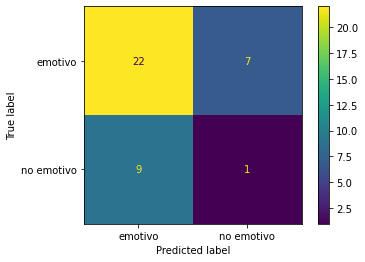

In [ ]:
#Modelo árbol de decisión: 
plot_confusion_matrix(tree, X_test, y_test)
plot.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


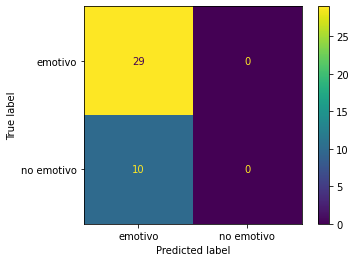

In [ ]:
#Modelo logística de regresión: 
plot_confusion_matrix(logreg_clf, X_test, y_test)
plot.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


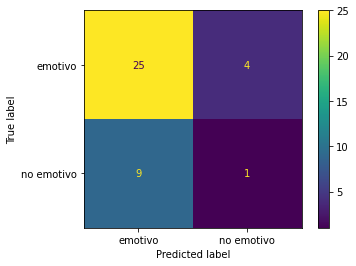

In [ ]:
#Modelo Kneighbors: 
plot_confusion_matrix(knn, X_test, y_test)
plot.show()

# Análisis de sentimientos 

A continuación mostraremos el código relativo a las herramientas que hemos empleado para realizar el análisis de sentimientos: 


**IBM WATSON**

In [ ]:
#Se importan los pqeutes necesarios y se identifica al usuario. Se aplica la función natural_language_understanding a una cadena de texto y devuelve un JSON con un análisis completo.
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions

authenticator = IAMAuthenticator(#Aquí se deben introducir las credenciales) 
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2021-08-01',
    authenticator=authenticator
)

natural_language_understanding.set_service_url('https://api.eu-gb.natural-language-understanding.watson.cloud.ibm.com/instances/0a8ea9e7-55c3-429f-91f1-e2083f9250d4')

"""
response = natural_language_understanding.analyze(
    url='www.cnn.com', features=Features(entities=EntitiesOptions(sentiment=True,limit=1))).get_result()
"""

response = natural_language_understanding.analyze(
    text= texto, features=Features(
        entities=EntitiesOptions(emotion=True, sentiment=True),
        keywords=KeywordsOptions(emotion=True, sentiment=True))).get_result()
print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 4,
    "text_characters": 31733,
    "features": 2
  },
  "language": "es",
  "keywords": [
    {
      "text": "caso Ayuso",
      "sentiment": {
        "score": -0.909903,
        "label": "negative"
      },
      "relevance": 0.567818,
      "count": 1
    },
    {
      "text": "denuncias de otros partidos",
      "sentiment": {
        "score": -0.971111,
        "label": "negative"
      },
      "relevance": 0.548774,
      "count": 1
    },
    {
      "text": "verg\u00fcenza de Espa\u00f1a",
      "sentiment": {
        "score": -0.896702,
        "label": "negative"
      },
      "relevance": 0.545095,
      "count": 1
    },
    {
      "text": "manos de Ayuso",
      "sentiment": {
        "score": -0.896702,
        "label": "negative"
      },
      "relevance": 0.532702,
      "count": 1
    },
    {
      "text": "monarqu\u00eda corrupta",
      "sentiment": {
        "score": -0.664838,
        "label": "negative"
      },
      "rel

In [ ]:
#Realiza un recuento de los sentimientos analizados.
positivas = 0
negativas = 0
neutras = 0
for element in response["keywords"]:
  current_score = element["sentiment"]["label"]
  if current_score == "positive":
    positivas += 1
  elif current_score== "negative":
    negativas += 1
  else:
    neutras += 1
print("positivos: " positivas)
print("negativos: "negativas)
print("neutras: "neutras)

6
41
3


**TRANSFORMERS**

In [ ]:
#Recuerda importar transformers y pipeline.

In [ ]:
#Comprueba que el texto a analizar no sea superior de 300 caracteres. Si lo es, lo divide y procede a realizar el análisis de sentimientos. 
def sentimiento_corte (comentario):
  inicio=0
  fin=300
  sentimientos={"NEG":0, "NEU":0, "POS":0}
  total=0 
  numelementos=0
  while inicio < len(comentario):
    result= sentiment_pipeline(comentario[inicio:fin])
    inicio= inicio + 300
    fin= fin+300
    sentimientos [result[0]["label"]]=sentimientos [result[0]["label"]]+ result[0]["score"]
  if sentimientos ["NEG"]> sentimientos["NEU"] and sentimientos["NEG"]> sentimientos ["POS"]:
    return "NEG"
  elif sentimientos ["NEU"]> sentimientos["NEG"] and sentimientos["NEU"]> sentimientos ["POS"]:
    return "NEU"
  else:
    return "POS"

In [ ]:
#Recorre una lista de comentarios y aplica la función anterior a todos ellos, eliminando los links de cada comentario si hubiese. 
def tsentimientos(listagrande):
  sentimiento=[]
  for comentario in listagrande:
      result=sentimiento_corte(quitar_links (comentario))
      sentimiento.append(result)
  return sentimiento


def csentimiento(listagrande):
  result= [sentimiento_corte(quitar_links(comentario))for comentario in listagrande]

  return (result)

In [ ]:
total_sentimientos=tsentimientos(listagrande)

In [ ]:
#Realiza un recuento de los sentimientos analizados.
positivo=0
negativo=0
neutro=0
for sentimiento in total_sentimientos:
  if sentimiento == "NEG":
    negativo=negativo + 1
  elif sentimiento == "NEU":
    neutro= neutro+1
  elif sentimiento== "POS":
    positivo=positivo + 1

print("positivos: ",positivo, "negativos: ", negativo, "neutros: ", neutro)

positivos:  7 negativos:  159 neutros:  32


In [ ]:
prueba= (["PP", "Partido Popular", "VOX", "PSOE", "Partido Socialista Obrero Español" "Podemos"])
sentiment_pipeline(prueba)


[{'label': 'NEU', 'score': 0.6393564343452454},
 {'label': 'NEU', 'score': 0.9033120274543762},
 {'label': 'NEU', 'score': 0.5628634095191956},
 {'label': 'NEU', 'score': 0.6345742344856262},
 {'label': 'NEU', 'score': 0.880187451839447}]